## Finite Element Method (FEM) discretization of the heat equation in two dimensions with FEniCS

<b>Goal</b>: This <a href="https://jupyter.org"> Jupyter</a> notebook aims at illustrating the use of FEniCS to discretize a time-dependent PDE (heat equation in two dimensions). We specifically learn how to define the problem inside FEniCS and learn how to handle the case of mixed boundary conditions.

<b>Note</b>: a cell is made active by first clicking on the left part of the web page (a blue vertical line appears) and then pushing Shift+Enter. 

<b>Note</b>: The next cell has to be activated only once and specifies the Python libraries we will use in this notebook. A basic knowledge of Python is only expected to understand the code used in the cells.  

In [1]:
#
# To allow plots within the Notebook 
#
%matplotlib inline

# Import here the standard Python libraries used in the Notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
import scipy.sparse as sps
import sys
import time

# Import FEniCS related libraries
from fenics import *
import dolfin as df

### Python version

In [2]:
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### <a href="https://fenicsproject.org">FEniCS</a> version 

In [3]:
print(df.__version__)

2019.1.0


### <a href="https://fenicsproject.org">Scipy</a> Linear algebra libraries

In [4]:
print(show_config())

mkl_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
system_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
None


# A.  2D heat equation:


We consider the two-dimensional heat equation defined for $t \in [0,T]$ with $T>0$, as
$$
\begin{array}{ll} 
    \displaystyle \frac{\partial}{\partial t} u(t,\boldsymbol x) - \text{div}\Big(\overline{\overline k}(\boldsymbol x)\cdot {grad} \ u(t,\boldsymbol x)\Big)&=& f , \quad \boldsymbol x \in \Omega, \\
                  u(t,\boldsymbol x) & = & u_D(t,\boldsymbol x)  \quad \boldsymbol x \in \Gamma_D, \\ 
     {\partial_n} u(t,\boldsymbol x) & = & u_N(t,\boldsymbol x) , \quad \boldsymbol x \in \Gamma_N, \\ 
    u(0, \boldsymbol x) & = & u_0(x), \quad \boldsymbol x \in \Omega, t=0,  \\
\end{array}
$$
with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega = \Gamma_D \cup \Gamma_N$ and ${\partial_n}u$ the normal derivative of $u$ on the boundary. 

$u(t,\boldsymbol x)$ denotes the temperature from the equilibrium position at point $\boldsymbol x \in \Omega $ and time $t$.  $\overline{\overline k} \in L^{\infty}(\Omega)$ (symmetric and coercive) denotes the conductivity coefficient. 


<b>Structure of this part</b>: This notebook first defines the continuous problem by using specific routines of FEniCS. Then we tackle the finite element discretization in space of the PDE. This discretization leads to a ODE formulation. After time discretization with the implicit Euler method, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

<b>Methodology</b>: To validate our implementation, we use the method of manufactured solutions. This means that we impose a solution to the time-dependent PDE above (satisfying the initial and boundary conditions respectively) and analytically compute the corresponding source term. We later check that the computed solution is in agreement with the imposed solution at each time step.

### Constants and parameters 

In [5]:
#
# Define constants related to the definition of the geometric rectangular domain
# x0, y0 are the coordinates of the bottom left point of the rectangle
# xL, yL are the coordinates of the top right point of the rectangle
#
x0, xL, y0, yL = 0., 2., 0., 1.
#
# Define constants related to the time discretization in [tinit,tfinal]
#
tinit  = 0.
tfinal = 4.
#
# Define the parameters related to the time discretization [only required for the Crank-Nicolson scheme]
# 
dt     = 5.e-2
theta  = 1.0
#
# Number of rectangles to be used in each direction for the mesh construction
#
nx = 20
ny = 20
#
# Degree of Lagrange approximation in space
#
deg = 2 
#
# Specify if the solution has to be stored in a VTK file for post-processing with Paraview
#
store = False
if store: vtkfile = File("./heat.pvd")
#
# Parameters related to the manufactured solution 
#
alpha = 3.
beta  = 1.
#
# Initial value for the time variable
#
t     = tinit

### FEniCS expressions definition
To define a function, the simplest way is to use a FEniCS Expression, which expresses the formula for the function in terms of the coordinates of the point (here x[0] and x[1] in two dimensions). When applicable, the other possibility is to use a FEniCS Constant statement.  

In [6]:
#
# Define Fenics Expressions or Constants
#

# Piecewise constant conductivity coefficient, with possibly a high conductivity in a subrectangle
# To specify k we use a FEniCS Expression which expresses the formula in terms of the coordinates
# of the point. The expression is a string that is parsed by a C++ compiler and so must be written in C++.
# DOLFIN_EPS is the machine precision used in FEniCS.
# Here we specify two different subdomains and may assign different values depending on the location. 
# degree is the degree of quadrature to be used later for k in the assembly process. 
k = Expression("x[0] > .5 - DOLFIN_EPS && x[0] < 1.25 + DOLFIN_EPS && x[1] < .75 + DOLFIN_EPS && x[1] > .5 - DOLFIN_EPS ? 1. : 1.", degree=2)

# Source term
# We use a Constant here due to the definition of the source term 
# that is related to the manufactured solution 
f = Expression('beta + 2 + 2*alpha',degree=2,alpha=alpha,beta=beta,t=t)

#
# Imposed manufactured solution 
#
u_M = Expression('x[0]*(Lx-x[0]) + alpha*x[1]*(Ly-x[1]) + beta*t',
                  degree=2, Lx= xL, Ly = yL, alpha=alpha, beta=beta, t=t)

#
# Neumann boundary condition on Gamma_N 
#
u_N = Expression('alpha*(Ly-2.*x[1])',degree=2, alpha=alpha, Ly = yL)

#
# Initial condition at time = tinit [u_M at time equal to 0]
#
u_0 = Expression("x[0]*(Lx-x[0]) + alpha*x[1]*(Ly-x[1])", degree=2, alpha=alpha, Lx= xL, Ly = yL)

### Problem at the continuous level
For all $t \in [0, T]$, given $T > 0$,  we seek a time dependent function $u$ in a trial space $V$ such that:
\begin{equation}
m(\frac{\partial{u}}{\partial{t}},v) + b(u,v) = l(v), \; \text{for all test functions} \; v \in V, \text{such as} \; v=0 \; \text{on} \; \Gamma_D, \\
\end{equation}
where the bilinear forms $m: V \times V \rightarrow \mathbb{R}$, $b: V \times V \rightarrow \mathbb{R}$ and the linear functional $l: V \rightarrow \mathbb{R}$ are given by:
\begin{equation}
m(u,v) = \int_{\Omega} u v dx, \quad 
b(u,v) = \int_{\Omega} k \, \nabla{u}\, . \, \nabla{v} dx, \quad l(v)= \int_{\Omega} f v dx + 
\int_{\Gamma_N} u_N v dx
\end{equation}

In [7]:
#
# Specify here the definition of the part of the boundary related to the Dirichlet boundary condition
#

only_Dirichlet = False

def Gamma_D(x, on_boundary):
    """
    This function should return a boolean value equal to true or false according to whether the point x 
    belongs to Gamma_D or not. 
    """
    if only_Dirichlet:
        return on_boundary
    else:
        return near(x[1], DOLFIN_EPS) or near(x[0], DOLFIN_EPS) or near(x[0], 2.) and on_boundary

### Problem at the discrete level in space and time
For the time discretization, we use the implicit Euler scheme which relies on a simple first order approximation of the time derivative of $u$. FEniCS's Unified Form Language (UFL) greatly simplifies the definition of the bilinear and linear forms at the discrete level as seen next for the space discretization. The idea is to write the complete variational formulation in a single statement and to use hereafter the lhs() and rhs() functions provided by FEniCS to deduce the bilinear and linear forms, respectively. 

Time spent in the meshing procedure:  0.00036217399999971533
Time spent in the finite element assembly procedure:  0.04285588399999973


Text(0.5, 1.05, 'Sparsity pattern of the implicit matrix')

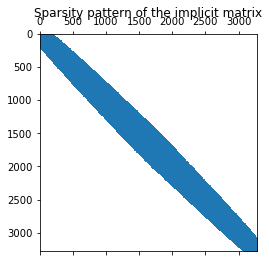

In [8]:
#
# Finite Element Space and Time discretization of the weak formulation
# 

# Generate the computational mesh 
# Here is the simplest way to discretize a rectangular domain with nx and ny rectangles in directions x and y,
# respectively. 
# The 'crossed' argument specifies that each rectangle will be divided into four triangles. 

meshing_start         = time.perf_counter()
mesh                  = RectangleMesh(Point(x0,y0), Point(xL,yL), nx, ny,'crossed')
meshing_time          = time.perf_counter()-meshing_start

# If the domain is the unit square, you may want to use instead
# mesh = UnitSquareMesh(nx, ny, 'crossed')
    
# Select the FE approximation space of Lagrange type
Vh  = FunctionSpace(mesh, "Lagrange", deg)
 
# Specify the Dirichlet boundary conditions 
bc = DirichletBC(Vh, u_M, Gamma_D)

#
# Define initial value or previous value: we interpolate the u_0 defined as a function 
# on the discrete space Vh
#
u_p = interpolate(u_0, Vh)

#    
# Discretization in space of the weak formulation 
#
assembly_start = time.perf_counter()

#
# The next two lines define two arguments that can be used as variables 
# to define the bilinear form (u as first argument, v as second)
#

u = TrialFunction(Vh)
v = TestFunction(Vh)

#
# We write the complete variational formulation corresponding to the theta-scheme
#
# Simplification here due to a time-independent term for the source terms ! 
#

#F = u*v*dx + theta*dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx + \
#    (1.-theta)*dt*dot(grad(u_n), grad(v))*dx - dt*u_N*v*ds

F      = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_p + dt*f)*v*dx - dt*u_N*v*ds

#
# Deduce the bilinear and linear forms of the variational formulation F using 
# the lhs and rhs functions
#

a, L   = lhs(F), rhs(F)

#
# Assemble the linear system taking into account the essential boundary conditions
#
A,b           = assemble_system(a,L,bc)
assembly_time = time.perf_counter()-assembly_start

#
# Timings
#

print("Time spent in the meshing procedure: ",meshing_time)
print("Time spent in the finite element assembly procedure: ",assembly_time)

#
# Sparsity pattern of A
# 
plt.figure()
plt.spy(sps.csr_matrix(A.array()))
plt.title("Sparsity pattern of the implicit matrix")

### Numerical approximation of the space-time solution

t = 0.05: error = 1.25e-13, maximum= 1.8, minimum= 0.05
t = 0.10: error = 2.2e-13, maximum= 1.85, minimum= 0.1
t = 0.15: error = 3.01e-13, maximum= 1.9, minimum= 0.15
t = 0.20: error = 3.72e-13, maximum= 1.95, minimum= 0.2
t = 0.25: error = 4.34e-13, maximum= 2, minimum= 0.25
t = 0.30: error = 4.89e-13, maximum= 2.05, minimum= 0.3
t = 0.35: error = 5.38e-13, maximum= 2.1, minimum= 0.35
t = 0.40: error = 5.83e-13, maximum= 2.15, minimum= 0.4
t = 0.45: error = 6.22e-13, maximum= 2.2, minimum= 0.45
t = 0.50: error = 6.58e-13, maximum= 2.25, minimum= 0.5
Timestep 10 Time 5.000e-01


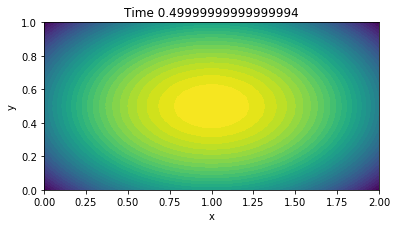

t = 0.55: error = 6.91e-13, maximum= 2.3, minimum= 0.55
t = 0.60: error = 7.22e-13, maximum= 2.35, minimum= 0.6
t = 0.65: error = 7.51e-13, maximum= 2.4, minimum= 0.65
t = 0.70: error = 7.8e-13, maximum= 2.45, minimum= 0.7
t = 0.75: error = 8.06e-13, maximum= 2.5, minimum= 0.75
t = 0.80: error = 8.33e-13, maximum= 2.55, minimum= 0.8
t = 0.85: error = 8.58e-13, maximum= 2.6, minimum= 0.85
t = 0.90: error = 8.82e-13, maximum= 2.65, minimum= 0.9
t = 0.95: error = 9.06e-13, maximum= 2.7, minimum= 0.95
t = 1.00: error = 9.3e-13, maximum= 2.75, minimum= 1
Timestep 20 Time 1.000e+00


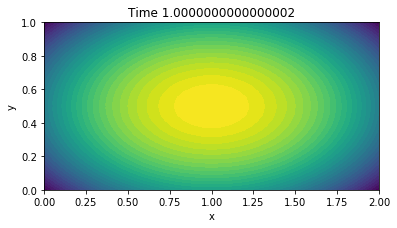

t = 1.05: error = 9.53e-13, maximum= 2.8, minimum= 1.05
t = 1.10: error = 9.76e-13, maximum= 2.85, minimum= 1.1
t = 1.15: error = 9.99e-13, maximum= 2.9, minimum= 1.15
t = 1.20: error = 1.02e-12, maximum= 2.95, minimum= 1.2
t = 1.25: error = 1.04e-12, maximum= 3, minimum= 1.25
t = 1.30: error = 1.07e-12, maximum= 3.05, minimum= 1.3
t = 1.35: error = 1.09e-12, maximum= 3.1, minimum= 1.35
t = 1.40: error = 1.11e-12, maximum= 3.15, minimum= 1.4
t = 1.45: error = 1.13e-12, maximum= 3.2, minimum= 1.45
t = 1.50: error = 1.16e-12, maximum= 3.25, minimum= 1.5
Timestep 30 Time 1.500e+00


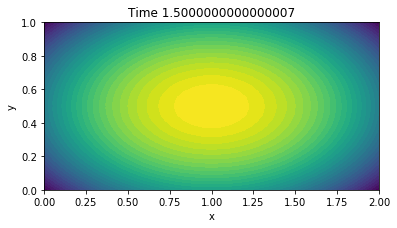

t = 1.55: error = 1.18e-12, maximum= 3.3, minimum= 1.55
t = 1.60: error = 1.2e-12, maximum= 3.35, minimum= 1.6
t = 1.65: error = 1.22e-12, maximum= 3.4, minimum= 1.65
t = 1.70: error = 1.25e-12, maximum= 3.45, minimum= 1.7
t = 1.75: error = 1.27e-12, maximum= 3.5, minimum= 1.75
t = 1.80: error = 1.29e-12, maximum= 3.55, minimum= 1.8
t = 1.85: error = 1.31e-12, maximum= 3.6, minimum= 1.85
t = 1.90: error = 1.33e-12, maximum= 3.65, minimum= 1.9
t = 1.95: error = 1.36e-12, maximum= 3.7, minimum= 1.95
t = 2.00: error = 1.38e-12, maximum= 3.75, minimum= 2
Timestep 40 Time 2.000e+00


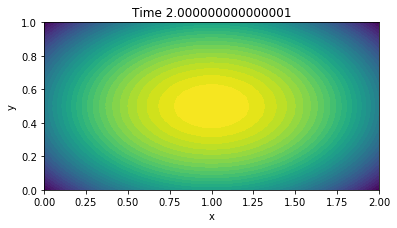

t = 2.05: error = 1.4e-12, maximum= 3.8, minimum= 2.05
t = 2.10: error = 1.42e-12, maximum= 3.85, minimum= 2.1
t = 2.15: error = 1.45e-12, maximum= 3.9, minimum= 2.15
t = 2.20: error = 1.47e-12, maximum= 3.95, minimum= 2.2
t = 2.25: error = 1.49e-12, maximum= 4, minimum= 2.25
t = 2.30: error = 1.51e-12, maximum= 4.05, minimum= 2.3
t = 2.35: error = 1.53e-12, maximum= 4.1, minimum= 2.35
t = 2.40: error = 1.56e-12, maximum= 4.15, minimum= 2.4
t = 2.45: error = 1.58e-12, maximum= 4.2, minimum= 2.45
t = 2.50: error = 1.6e-12, maximum= 4.25, minimum= 2.5
Timestep 50 Time 2.500e+00


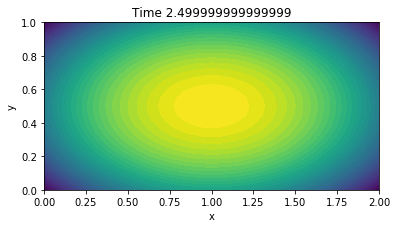

t = 2.55: error = 1.62e-12, maximum= 4.3, minimum= 2.55
t = 2.60: error = 1.64e-12, maximum= 4.35, minimum= 2.6
t = 2.65: error = 1.67e-12, maximum= 4.4, minimum= 2.65
t = 2.70: error = 1.69e-12, maximum= 4.45, minimum= 2.7
t = 2.75: error = 1.71e-12, maximum= 4.5, minimum= 2.75
t = 2.80: error = 1.73e-12, maximum= 4.55, minimum= 2.8
t = 2.85: error = 1.76e-12, maximum= 4.6, minimum= 2.85
t = 2.90: error = 1.78e-12, maximum= 4.65, minimum= 2.9
t = 2.95: error = 1.8e-12, maximum= 4.7, minimum= 2.95
t = 3.00: error = 1.82e-12, maximum= 4.75, minimum= 3
Timestep 60 Time 3.000e+00


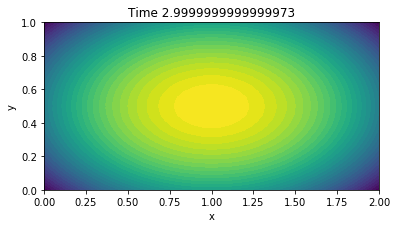

t = 3.05: error = 1.84e-12, maximum= 4.8, minimum= 3.05
t = 3.10: error = 1.87e-12, maximum= 4.85, minimum= 3.1
t = 3.15: error = 1.89e-12, maximum= 4.9, minimum= 3.15
t = 3.20: error = 1.91e-12, maximum= 4.95, minimum= 3.2
t = 3.25: error = 1.93e-12, maximum= 5, minimum= 3.25
t = 3.30: error = 1.95e-12, maximum= 5.05, minimum= 3.3
t = 3.35: error = 1.98e-12, maximum= 5.1, minimum= 3.35
t = 3.40: error = 2e-12, maximum= 5.15, minimum= 3.4
t = 3.45: error = 2.02e-12, maximum= 5.2, minimum= 3.45
t = 3.50: error = 2.04e-12, maximum= 5.25, minimum= 3.5
Timestep 70 Time 3.500e+00


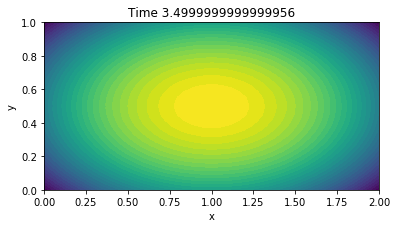

t = 3.55: error = 2.07e-12, maximum= 5.3, minimum= 3.55
t = 3.60: error = 2.09e-12, maximum= 5.35, minimum= 3.6
t = 3.65: error = 2.11e-12, maximum= 5.4, minimum= 3.65
t = 3.70: error = 2.13e-12, maximum= 5.45, minimum= 3.7
t = 3.75: error = 2.16e-12, maximum= 5.5, minimum= 3.75
t = 3.80: error = 2.18e-12, maximum= 5.55, minimum= 3.8
t = 3.85: error = 2.2e-12, maximum= 5.6, minimum= 3.85
t = 3.90: error = 2.22e-12, maximum= 5.65, minimum= 3.9
t = 3.95: error = 2.24e-12, maximum= 5.7, minimum= 3.95
t = 4.00: error = 2.26e-12, maximum= 5.75, minimum= 4
Timestep 80 Time 4.000e+00


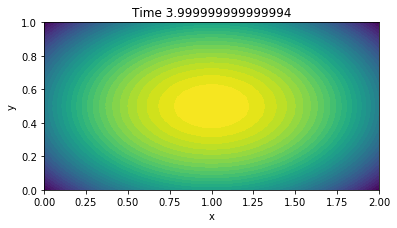

In [10]:
#
# Numerical Approximation of the space-time solution
#
t     = tinit
tstep = 0


# Store the initial condition if required
u_p.rename("u", "Temperature") 
if store: vtkfile << u_n

#
# Time-integration 
#
u = Function(Vh, name="u")
#
# Define which type of iterative solver we want to use
#
solver                                     = LUSolver(A,method='mumps')
solver.parameters['symmetric']             = True  
solver.parameters['report']                = True  
solver.parameters['verbose']               = True 


while t + dt <= tfinal:
    t     += dt
    tstep += 1
    # Specify the parameter t of the u_M function [exact solution]
    u_M.t  = t 
    # Specify the parameter t of the f function [source term]
    f.t    = t
    # Specify the boundary conditions on Gamma_D that may be time dependent
    bc     = DirichletBC(Vh, u_M, Gamma_D)
    # Deduce the bilinear and linear forms from F [UFL]
    a, L   = lhs(F), rhs(F)
    
    # Solve the linear system to obtain the approximation of the solution at time t
    # We use assemble_system to keep the symmetry nature of the system
    A, b = assemble_system(a, L, bc)
    
    # We call the specific solver here to deduce the vector related to the function u
    solver.solve(u.vector(),b)
    
    # Store the current solution as a function if required
    if store: vtkfile << u
    
    # We check our implementation by computing the error between the computed and manufactured
    # solutions.
    #
    # Compute error at vertices 
    # Interpolate first the exact solution on the discrete space Vh
    u_e           = interpolate(u_M, Vh)
    error         = np.abs(u_e.vector() - u.vector()).max()
    maximum_value = u.vector().max()
    minimum_value = u.vector().min()
    print('t = %.2f: error = %.3g, maximum= %.3g, minimum= %.3g' % (t, error, maximum_value, minimum_value))
  
    # Prepare the next iteration in time 
    u_p.assign(u)
    
    # Monitor the time integration
    if tstep%10 == 0:
       print("Timestep %g"% tstep, "Time %2.3e" %t)
       plt.figure()
       plot(u)
       plt.xlabel('x')
       plt.ylabel('y')
       plt.title('Time '+ str(t))
       plt.show()

### Post-processing

In [ ]:
#
# We plot the finite element mesh
# 
print(u.vector().size())
plot(mesh)

In [ ]:
#
# A very basic post-processing
# We plot the solution at final time
#
plt.figure()
plot(u)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the heat equation at final time')
#
# If movie=True, paraview can be used to read the file (evolution of the solution versus time)
#

## Task:
Modify the code above to implement the Crank-Nicolson scheme which is second order accurate in time and unconditionnaly stable. Check again your implementation by obtaining an error between the computed and selected manufactured solutions close to the machine precision. 

### Feedback / Your comments or notes

# Further information

- <a href="https://fenicsproject.org">FEniCS website</a>. 

- <a href="https://fenicsproject.org/tutorial">FEniCS tutorials</a>.